In [1]:
import os
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model

from sklearn.metrics import roc_curve,roc_auc_score

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def DrawPics(tensor,nb=0,template='{}',classnumber=None):
    if (nb==0):
        N = tensor.shape[0]
    else:
        N = min(nb,tensor.shape[0])
    fig=plt.figure(figsize=(16,2))
    nbligne = floor(N/20)+1
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis("off")
        plt.imshow(tensor[m,:,:,0],vmin=0, vmax=1,cmap='Greys')
        if (classnumber!=None):
            subplot.title.set_text((template.format(classnumber)))

In [3]:
model_path = './weights_quadlosssimple/'

### Generation des images


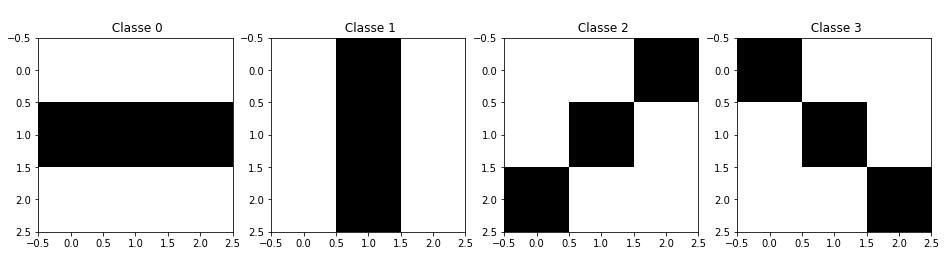

In [4]:
#Generation des 4 images de base => (4,3,3,1)
basepicture =np.zeros((4,3,3,1))
for m in range(4):
    if (m==0):
        #Horizontale        
        for j in range(3):
            basepicture[m,1,j,0] = 1
    if (m==1):
        #Vertical
        for j in range(3):
            basepicture[m,j,1,0] = 1
    if (m==2):
        #Diag
        for j in range(3):
            basepicture[m,2-j,j,0] = 1
    if (m==3):
        #Backslash
        for j in range(3):
            basepicture[m,j,j,0] = 1

basepictureH = basepicture[0,:,:,0]
basepictureV = basepicture[1,:,:,0]
basepictureD = basepicture[2,:,:,0]
basepictureB = basepicture[3,:,:,0]
fig=plt.figure(figsize=(16,16))
template=('\n Classe {}')
for classe in range(4):
    subplot = fig.add_subplot(1,4,classe+1)
    plt.imshow(basepicture[classe,:,:,0],vmin=0, vmax=1,cmap='Greys')
    subplot.title.set_text((template.format(classe)))





## Generation dataset

In [5]:
nb_classes = 4
img_rows, img_cols = 3, 3
input_shape = (img_rows, img_cols, 1)

def buildDataSet(basepicture, nb_image_per_class=1, noise_amplitude=0.2):
    """Generation d'image en rajoutant du bruit sur les images de base
    
    
    returns:
        dataset : tableau (N) contenant les images pour chacune des classes (nb_image_per_class,3,3,1)
    """
    N,w,h,c = basepicture.shape
    
    SplitTrainTest = 0.7
    nb_train_sample = int(nb_image_per_class*SplitTrainTest)
    nb_test_sample = nb_image_per_class-nb_train_sample
    
    dataset_train = [np.zeros((nb_train_sample,h, w,c)) for i in range(N)]
    dataset_test = [np.zeros((nb_test_sample,h, w,c)) for i in range(N)]
    
    for n in range(N):
        #Genere la matrice de bruit pour toutes les images
        dataset_train[n] = np.random.uniform(0,noise_amplitude,(nb_train_sample,w,h,c))
        dataset_test[n] = np.random.uniform(0,noise_amplitude,(nb_test_sample,w,h,c))
        
        #Ajoute l'image de base au bruit existant
        for x in range(nb_train_sample):
            dataset_train[n][x,:,:,0] += basepicture[n,:,:,0]
            
        for x in range(nb_test_sample):
            dataset_test[n][x,:,:,0] += basepicture[n,:,:,0]
            
        #Clip les valeurs en dehors de 0 1
        dataset_train[n] = np.clip(dataset_train[n],0,1)
        dataset_test[n] = np.clip(dataset_test[n],0,1)
        
    return dataset_train,dataset_test

(700, 3, 3, 1)
(300, 3, 3, 1)
dataset train : 4x (700, 3, 3, 1)
dataset test : 4x (300, 3, 3, 1)


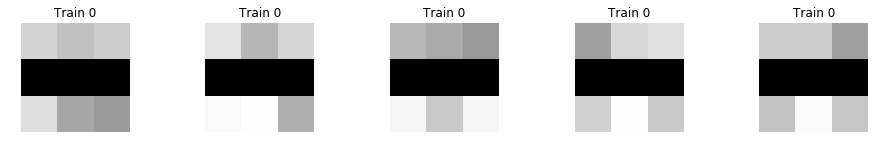

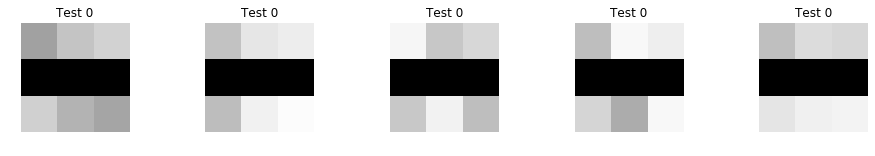

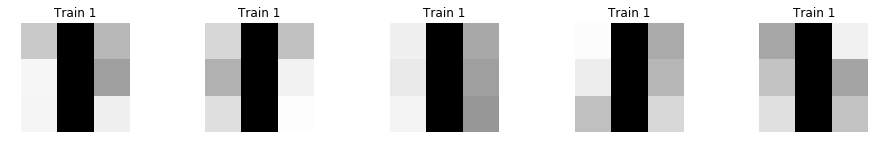

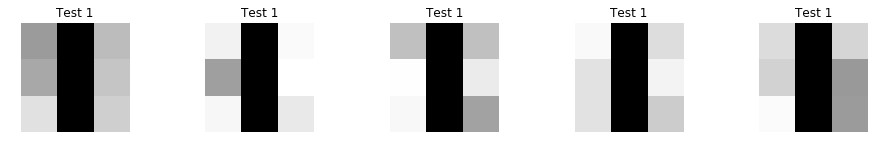

In [6]:
dataset_train,dataset_test = buildDataSet(basepicture, nb_image_per_class=1000, noise_amplitude=0.5)
dataset_test_flat_X = np.concatenate((dataset_test[0],dataset_test[1],dataset_test[2],dataset_test[3]),axis=0)
dataset_test_flat_Y = np.concatenate((np.ones((dataset_test[0].shape[0]))*0,np.ones((dataset_test[0].shape[0]))*1,np.ones((dataset_test[0].shape[0]))*2,np.ones((dataset_test[0].shape[0]))*3),axis=0)
print(dataset_train[0].shape)
print(dataset_test[0].shape)
print("dataset train : 4x",dataset_train[0].shape)
print("dataset test : 4x",dataset_test[0].shape)
for i in range(2):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)


### Definition du modele de similarité

In [7]:
def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(4, (3,3), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(Flatten())
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
class QuadrupletLossLayer(Layer):
    def __init__(self, alpha, beta, **kwargs):
        self.alpha = alpha
        self.beta = beta
        super(QuadrupletLossLayer, self).__init__(**kwargs)
    
    def quadruplet_loss(self, inputs):
        anchor, positive, negative, negative2 = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        n2_dist = K.sum(K.square(negative-negative2), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0) + K.sum(K.maximum(p_dist - n2_dist + self.beta, 0), axis=0)
    
    def call(self, inputs):
        loss = self.quadruplet_loss(inputs)
        self.add_loss(loss)
        return loss

def build_model3(input_shape, network, margin=0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

def build_model4(input_shape, network, margin=0.2, margin2=0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the four input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    negative2_input = Input(input_shape, name="negative2_input")
    
    # Generate the encodings (feature vectors) for the four images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    encoded_n2 = network(negative2_input)
    
    #QuadrupletLoss Layer
    loss_layer = QuadrupletLossLayer(alpha=margin,beta=margin2,name='quadruplet_loss_layer')([encoded_a,encoded_p,encoded_n, encoded_n2])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input,negative2_input],outputs=loss_layer)
    
    # return the model
    return network_train

In [8]:
#modele en 3xloss
network3 = build_network(input_shape,embeddingsize=2)
network3_train = build_model3(input_shape,network3)
optimizer3 = Adam(lr = 0.00006)
network3_train.compile(loss=None,optimizer=optimizer3)
network3_train.summary()
plot_model(network3_train,show_shapes=True, show_layer_names=True, to_file='10 model.png')


#modele en 4xloss
network4 = build_network(input_shape,embeddingsize=2)
network4.set_weights(network3.get_weights()) #copy weights to have identical networks
network4_train = build_model4(input_shape,network4)
optimizer4 = Adam(lr = 0.00006)
network4_train.compile(loss=None,optimizer=optimizer4)
network4_train.summary()
plot_model(network4_train,show_shapes=True, show_layer_names=True, to_file='10 model4.png')



n_iteration=0
#network_train.load_weights('mnist-160k_weights.h5')

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output triplet_loss_layer missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to triplet_loss_layer.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2)            50          anchor_input[0][0]               
                                                                 positive_input[0][0]       

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output quadruplet_loss_layer missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to quadruplet_loss_layer.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
negative2_input (InputLayer)    (None, 3, 3, 1)      0                                            
____________________________________________________________________________________________

![alt text](10 model.png " ")
![alt text](10 model4.png " ")

In [9]:
#testing our NN with dummy image
featured_img = network3.predict(np.ones((1,img_rows,img_cols,1)))
print(featured_img)

[[-0.63214976 -0.7748462 ]]


### Preparing batch for training


In [10]:
def get_batch_random(batch_size,s="train"):
    """
    Create batch of APN quadruplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 

    Returns:
    quadruplets -- list containing 4 tensors A,P,N,N2 of shape (batch_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    
    # initialize result
    quadruplets=[np.zeros((batch_size,h, w,c)) for i in range(4)]
    
    for i in range(batch_size):
        #Pick one random class for anchor
        anchor_class = np.random.randint(0, nb_classes)
        nb_sample_available_for_class_AP = X[anchor_class].shape[0]
        
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] = np.random.choice(nb_sample_available_for_class_AP,size=2,replace=False)
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes
        nb_sample_available_for_class_N = X[negative_class].shape[0]
        
        #Pick a random pic for this negative class => N
        idx_N = np.random.randint(0, nb_sample_available_for_class_N)
        
        #Pick another class for N2, different from anchor_class and negative_class
        remainingClasses = np.setdiff1d(range(nb_classes),[anchor_class,negative_class])
        negative2_class = np.random.choice(remainingClasses,1)[0]
        nb_sample_available_for_class_N2 = X[negative2_class].shape[0]
                                        
        #Pick a random pic for this negative class => N2
        idx_N2 = np.random.randint(0, nb_sample_available_for_class_N2)

        quadruplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        quadruplets[1][i,:,:,:] = X[anchor_class][idx_P,:,:,:]
        quadruplets[2][i,:,:,:] = X[negative_class][idx_N,:,:,:]
        quadruplets[3][i,:,:,:] = X[negative2_class][idx_N2,:,:,:]

    return quadruplets

def drawQuadriplets(quadripletbatch, nbmax=None):
    """display the four images for each quadriplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative", "Negative2"]

    if (nbmax==None):
        nbrows = quadripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,quadripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(4):
            subplot = fig.add_subplot(1,4,i+1)
            axis("off")
            plt.imshow(quadripletbatch[i][row,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(labels[i])

In [11]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))

def get_batch_hard(draw_batch_size,hard_batchs_size,norm_batchs_size,network,s="train"):
    """
    Create batch of APN "hard" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_random(draw_batch_size,s)
    
    #Step 2 : compute the loss with current network : d(A,P)-d(A,N). The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((draw_batch_size))
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    P = network.predict(studybatch[1])
    N = network.predict(studybatch[2])
    
    #Compute d(A,P)-d(A,N)
    studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the 
    selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    selection = np.append(selection,selection2)
    
    triplets = [studybatch[0][selection,:,:,:], studybatch[1][selection,:,:,:], studybatch[2][selection,:,:,:]]
    
    return triplets

def get_batch(batch_size,s="train"):
    """
    Create batch of n pairs, half same class, half different class
    
    Arguments:
    batch_size -- integer 

    Returns:
    pairs -- tableau (2,batchsize) contenant les 2 images left,right de shape (batch_size,w,h,c)
    targets -- tableau (2,batchsize) contenant les labels des images left et right 
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test
    m, w, h,c = X[0].shape
    
    # randomly sample several classes to use in the batch
    n_classes = len(dataset_train)
    categories = np.random.choice(n_classes,size=(batch_size,),replace=True)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,c)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # La premiere moitie du batch sont des paires de memes classes (=1), la deuxieme moitié differentes (=0)
    targets[:batch_size//2] = 1
    
    for i in range(batch_size):
        category = categories[i] #classe
        
        #une image au hasard de cette classe
        idx_1 = np.random.randint(0, m) 
        pairs[0][i,:,:,:] = X[category][idx_1,:,:,:]
        
        # pick images of same class for 1st half, different for 2nd
        if i < batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        idx_2 = np.random.randint(0, m)
        pairs[1][i,:,:,:] = X[category_2][idx_2,:,:,:]
    
    return pairs, targets

Checking batch width, should be 4 :  4
Shapes in the batch A:(2, 3, 3, 1) P:(2, 3, 3, 1) N:(2, 3, 3, 1) N2:(2, 3, 3, 1)


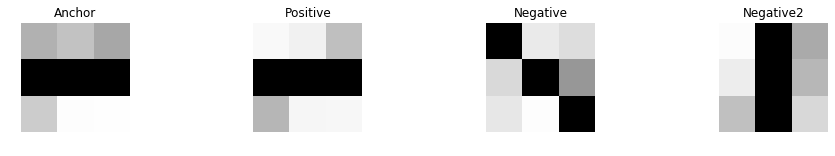

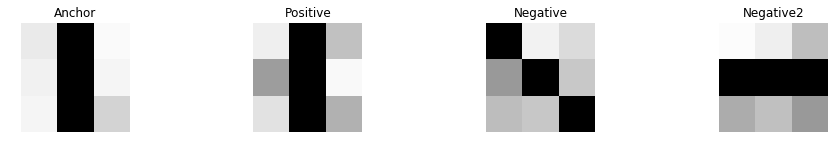

In [12]:
quadruplets = get_batch_random(2)
print("Checking batch width, should be 4 : ",len(quadruplets))
print("Shapes in the batch A:{0} P:{1} N:{2} N2:{3}".format(quadruplets[0].shape, quadruplets[1].shape, quadruplets[2].shape, quadruplets[3].shape))
drawQuadriplets(quadruplets)
#hardtriplets = get_batch_hard(50,1,1,network3)
#print("Shapes in the hardbatch A:{0} P:{1} N:{2}".format(hardtriplets[0].shape, hardtriplets[1].shape, hardtriplets[2].shape))
#drawTriplets(hardtriplets)

### Validation / evaluation



In [13]:

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,img_rows,img_cols,1))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network,n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))

    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds,auc,n_iteration):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f} @ {4} iterations\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold),n_iteration ))
    # show the plot
    plt.show()
    
def draw_roc_dual(fpr1, tpr1,thresholds1,auc1,fpr2, tpr2,thresholds2,auc2,n_iteration, name1, name2):
    #find threshold
    targetfpr=1e-3
    _, idx1 = find_nearest(fpr1,targetfpr)
    threshold1 = thresholds1[idx1]
    recall1 = tpr1[idx1]
    _, idx2 = find_nearest(fpr2,targetfpr)
    threshold2 = thresholds2[idx2]
    recall2 = tpr2[idx2]
    
    fig=plt.figure(figsize=(16,6))
    
    subplot = fig.add_subplot(1,2,1)   
    # plot no skill
    subplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    subplot.plot(fpr1, tpr1, marker='.')
    subplot.title.set_text('{5}\nAUC: {0:.3f} @ {4} iterations\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc1,targetfpr,recall1,abs(threshold1),n_iteration,name1 ))
    
    subplot = fig.add_subplot(1,2,2)   
    # plot no skill
    subplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    subplot.plot(fpr2, tpr2, marker='.')
    subplot.title.set_text('{5}\nAUC: {0:.3f} @ {4} iterations\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc2,targetfpr,recall2,abs(threshold2),n_iteration,name2 ))
    
    # show the plot
    fig.show()
    
def draw_embeddings(network):
    basepredict = network.predict(basepicture)
    plt.scatter(basepredict[:,0],basepredict[:,1])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    for i in range(4):
        plt.annotate(i, (basepredict[i,0], basepredict[i,1]))

    for i in range(4):
        preds = network.predict(dataset_test[i])
        plt.scatter(preds[:,0],preds[:,1])
        
def draw_embeddings_dual(network1, network2):
    basepredict1 = network1.predict(basepicture)
    basepredict2 = network2.predict(basepicture)
    fig = plt.figure(figsize=(16,6))
    
    subplot = fig.add_subplot(1,2,1)   
    subplot.scatter(basepredict1[:,0],basepredict1[:,1])
    subplot.set_xlim([-1, 1])
    subplot.set_ylim([-1, 1])
    for i in range(4):
        subplot.annotate(i, (basepredict1[i,0], basepredict1[i,1]))

    for i in range(4):
        preds = network1.predict(dataset_test[i])
        subplot.scatter(preds[:,0],preds[:,1])
        
    subplot = fig.add_subplot(1,2,2)   
    subplot.scatter(basepredict2[:,0],basepredict2[:,1])
    subplot.set_xlim([-1, 1])
    subplot.set_ylim([-1, 1])
    for i in range(4):
        subplot.annotate(i, (basepredict2[i,0], basepredict2[i,1]))

    for i in range(4):
        preds = network2.predict(dataset_test[i])
        subplot.scatter(preds[:,0],preds[:,1])
        
        
def draw_eval(network,n_iteration):
    probs,yprob = compute_probs(network, dataset_test_flat_X,dataset_test_flat_Y)
    fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr,thresholds,auc,n_iteration)
    draw_embeddings(network)
    draw_interdist(network,n_iteration)
    
def draw_eval_dual(network1,network2,n_iteration):
    probs1,yprob1 = compute_probs(network1, dataset_test_flat_X,dataset_test_flat_Y)
    probs2,yprob2 = compute_probs(network2, dataset_test_flat_X,dataset_test_flat_Y)
    fpr1, tpr1, thresholds1,auc1 = compute_metrics(probs1,yprob1)
    fpr2, tpr2, thresholds2,auc2 = compute_metrics(probs2,yprob2)
        
    draw_roc_dual(fpr1, tpr1,thresholds1,auc1,fpr2, tpr2,thresholds2,auc2,n_iteration, "Triplet", "Quadruplet")
    draw_embeddings_dual(network1,network2)
    draw_interdist(network1, n_iteration)
    draw_interdist(network2, n_iteration)
    


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:75: MatplotlibDeprecationWarning: numpy.hypot


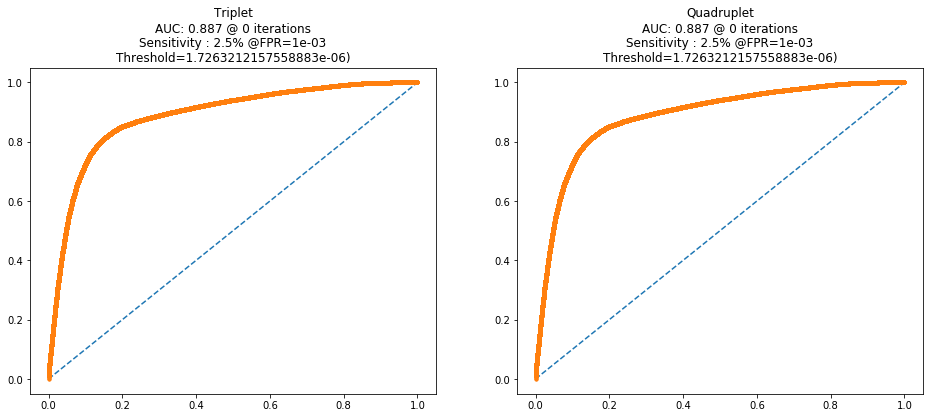

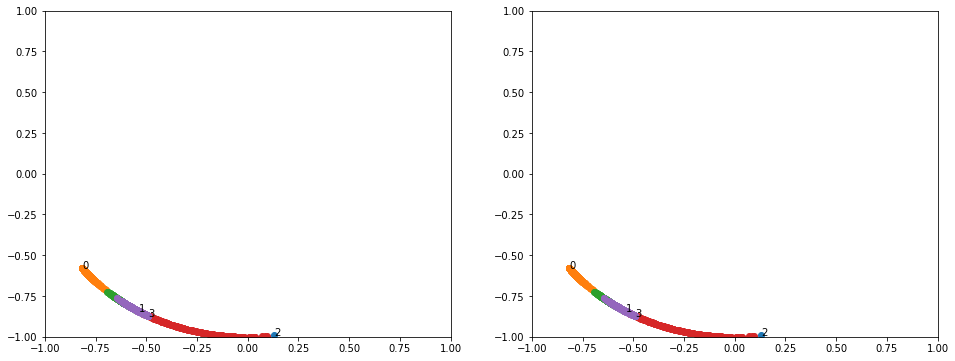

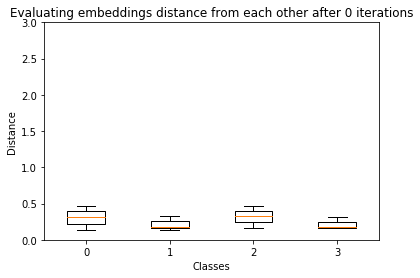

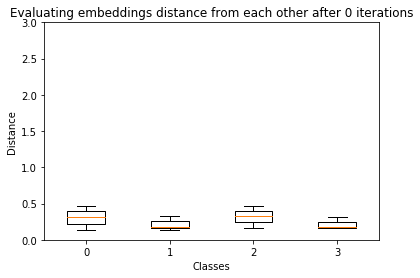

In [14]:
#Testing on an untrained network
draw_eval_dual(network3,network4,n_iteration)

In [15]:
def DrawTestImage(network, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = dataset_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][refidx,:,:,:]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        plt.imshow(images[i,:,:,0],vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text("Test image")
            
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            plt.imshow(ref_images[ref,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

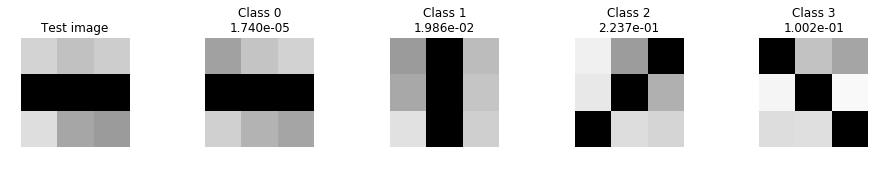

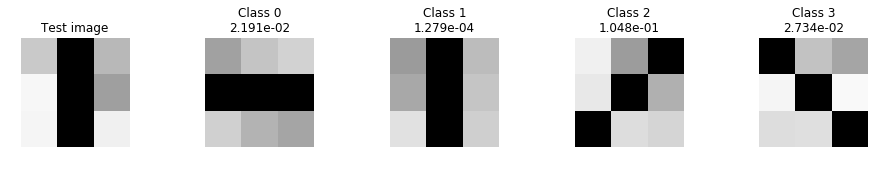

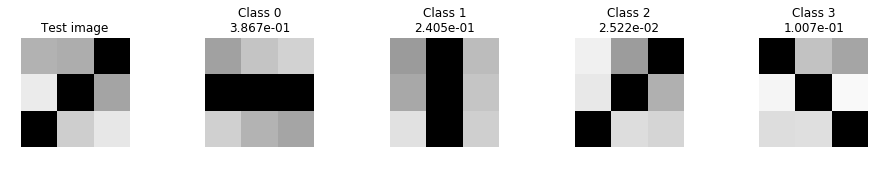

In [16]:
for i in range(3):
    DrawTestImage(network3,np.expand_dims(dataset_train[i][0,:,:,:],axis=0))

### Training

In [17]:
# Hyper parameters
evaluate_every = 1000 # interval for evaluating on one-shot tasks
batch_size = 16
n_iter = 15000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on

In [18]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    quadruplets = get_batch_random(16)
    triplets = quadruplets[:3]
    loss1 = network3_train.train_on_batch(triplets, None)
    loss2 = network4_train.train_on_batch(quadruplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        #print("\n ------------- \n")
        print("[{4}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2} {3}".format(i, (time.time()-t_start)/60.0,loss1,loss2,n_iteration))
        #probs,yprob = compute_probs(network3,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        #draw_roc(fpr, tpr)

Starting training process!
-------------------------------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[1000] Time for 1000 iterations: 0.3 mins, Train Loss: 0.1938803344964981 0.52181077003479
[2000] Time for 2000 iterations: 0.5 mins, Train Loss: 0.9808148741722107 1.3230363130569458
[3000] Time for 3000 iterations: 0.7 mins, Train Loss: 0.12620538473129272 0.5932618975639343
[4000] Time for 4000 iterations: 0.9 mins, Train Loss: 0.04712875187397003 0.11417894810438156
[5000] Time for 5000 iterations: 1.1 mins, Train Loss: 0.2187950611114502 0.21121758222579956
[6000] Time for 6000 iterations: 1.3 mins, Train Loss: 0.28224921226501465 0.18849749863147736
[7000] Time for 7000 iterations: 1.5 mins, Train Loss: 0.1329375058412552 0.1672639548778534
[8000] Time for 8000 iterations: 1.7 mins, Train Loss: 0.01935543864965439 0.039553456008434296
[9000] Time for 9000 iterations: 1.9 mins, Train Loss: 0.005121008958667517 0.005367078818

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:75: MatplotlibDeprecationWarning: numpy.hypot


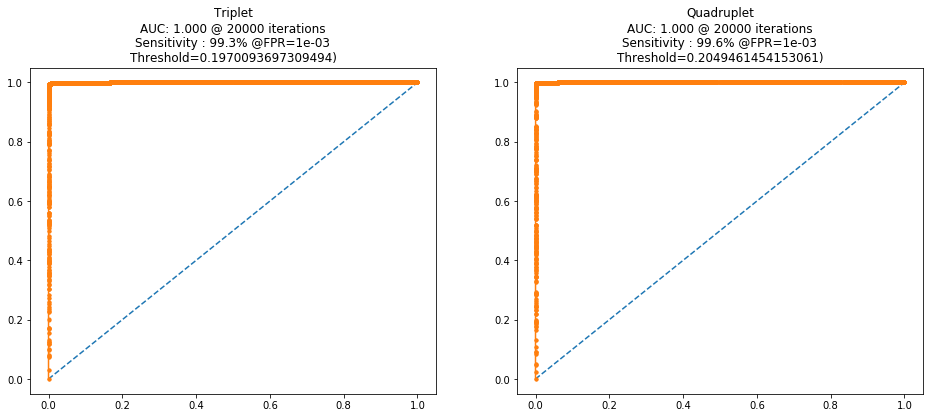

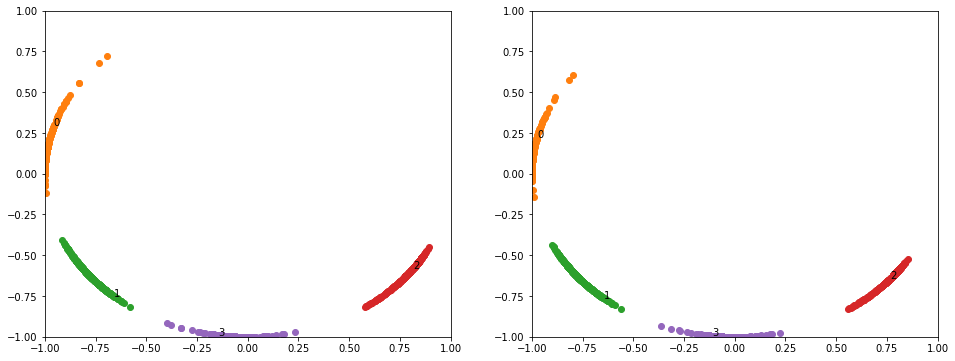

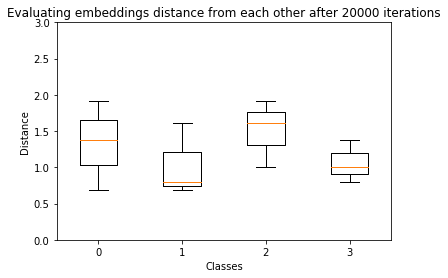

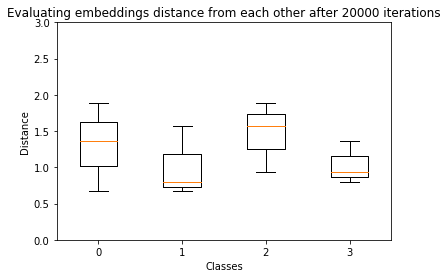

In [19]:
#Full evaluation
draw_eval_dual(network3,network4,n_iteration)